_This notebook contains code and comments from Section 3.4 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## Estudio de caso: Análisis de sentimientos

El análisis de sentimientos es una tarea de procesamiento del lenguaje natural (PNL) para identificar la polaridad de la opinión como positiva, neutral o negativa. Este estudio de caso explora una tarea de análisis de opinión supervisada para reseñas de películas. El conjunto de datos que usaremos es el [Conjunto de datos de reseñas de películas grandes](https://ai.stanford.edu/~amaas/data/sentiment/), que originalmente se recopiló y seleccionó para un artículo de 2011 sobre análisis de sentimientos:

Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). _Learning Word Vectors for Sentiment Analysis_. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

In [2]:
# Data directory relative to this notebook
sentiment_data_directory = './data/ch03/'

### Preprocesamiento
Este conjunto de datos ya ha sido preprocesado por [vectorización de conteo](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) para generar [características de bolsa de palabras](https://en.wikipedia.org/wiki/Bag-of-words_model). Estas funciones de recuento de documentos de términos preprocesados, nuestro conjunto de datos, se pueden encontrar en ``./data/ch03/train/labeledBow.feat`` y ``./data/ch03/test/labeledBow.feat``.

#### Eliminación de palabras vacías
Este paso tiene como objetivo eliminar palabras comunes como "el", "es", "un" (“the”, “is”, “a”, “an”). La eliminación de palabras vacías puede reducir la dimensionalidad de los datos (para acelerar el procesamiento) y puede mejorar el rendimiento de la clasificación. Esto se debe a que palabras como "el" a menudo no son realmente informativas para la recuperación de información y las tareas de minería de texto.

**Apartado 3.11**: Elimina las palabras vacías del vocabulario

In [3]:
import nltk
import time
import numpy as np

def prune_vocabulary(data_path, max_features=5000):
    start_time = time.time()
    with open('{0}/imdb.vocab'.format(data_path), 'r', encoding='utf8') as vocab_file:
        vocabulary = vocab_file.read().splitlines()
    print('Vocabulary load time = {0} seconds.'.format(time.time() - start_time))

    # Convert the list of stopwords to a set for faster processing
    # nltk.download('stopwords')   # **** UNCOMMENT THIS LINE IF YOU HAVEN'T USED NLTK BEFORE ***
    stopwords = set(nltk.corpus.stopwords.words("english"))

    # Keep only those vocabulary words that are NOT stopwords
    to_keep = [True if word not in stopwords else False for word in vocabulary]
    feature_ind = np.where(to_keep)[0]

    return feature_ind[:max_features]

In [4]:
features = prune_vocabulary(sentiment_data_directory, max_features=5000)

Vocabulary load time = 0.03064250946044922 seconds.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lasm1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


#### Transformación TF-IDF
Nuestro segundo paso de preprocesamiento convierte las características de recuento en [características tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Estas características representan el término frecuencia inversa de frecuencia del documento, una estadística que pondera cada característica de un documento (en nuestro caso, una sola revisión) en relación con la frecuencia con la que aparece en ese documento y con la frecuencia con la que aparece en todo el corpus (en nuestro caso, todas las revisiones).

Podemos usar la caja de herramientas de preprocesamiento de scikit-learn para convertir nuestras funciones de conteo en funciones tf-idf usando [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

**Apartado 3.12**: Extraiga características de tf-idf y guarde el conjunto de datos (**NOTA: _genera un archivo de 41 MB_**)

In [5]:
import h5py
from sklearn.datasets import load_svmlight_files
from scipy.sparse import csr_matrix as sp
from sklearn.feature_extraction.text import TfidfTransformer

def preprocess_and_save(data_path, feature_ind):
    data_files = ['{0}/{1}/labeledBow.feat'.format(data_path, data_set) 
                  for data_set in ['train', 'test']]
    [Xtrn, ytrn, Xtst, ytst] = load_svmlight_files(data_files)
    n_features = len(feature_ind)

    ytrn[ytrn <= 5], ytst[ytst <= 5] = 0, 0
    ytrn[ytrn > 5], ytst[ytst > 5] = 1, 1

    # Transform the bag-of-words
    tfidf = TfidfTransformer()
    Xtrn = tfidf.fit_transform(Xtrn[:, feature_ind])
    Xtst = tfidf.transform(Xtst[:, feature_ind])
      
    # Save the data in HDF5 format with sparse matrix representation
    with h5py.File('{0}/imdb-{1}k.h5'.format(data_path, 
                            round(n_features/1000)), 'w') as db:
        db.create_dataset('Xtrn', 
                          data=sp.todense(Xtrn), compression='gzip')
        db.create_dataset('ytrn', data=ytrn, compression='gzip')
        db.create_dataset('Xtst', 
                          data=sp.todense(Xtst), compression='gzip')
        db.create_dataset('ytst', data=ytst, compression='gzip')

In [6]:
preprocess_and_save(sentiment_data_directory, features)

---
### Reducción de dimensionalidad 

Adoptamos el popular enfoque de reducción de la dimensionalidad de [análisis de componentes principales](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA), que tiene como objetivo comprimir e incorporar los datos en una representación de menor dimensión mientras se conserva la mayor cantidad de información posible.

Para evitar cargar todo el conjunto de datos en la memoria y procesar los datos de manera más eficiente, realizamos [Incremental PCA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_incremental_pca.html) en su lugar.

**Apartado 3.13**: Realice reducción de dimensionalidad usando PCA Incremental (**NOTA: _genera un archivo de 187 MB_**)

In [7]:
from sklearn.decomposition import IncrementalPCA

def transform_sentiment_data(data_path, n_features=5000, n_components=500):
    db = h5py.File('{0}/imdb-{1}k.h5'.format(data_path, round(n_features/1000)), 'r')

    pca = IncrementalPCA(n_components=n_components)
    chunk_size = 1000
    n_samples = db['Xtrn'].shape[0] 
    for i in range(0, n_samples // chunk_size):
        pca.partial_fit(db['Xtrn'][i*chunk_size:(i+1) * chunk_size])

    Xtrn = pca.transform(db['Xtrn'])
    Xtst = pca.transform(db['Xtst'])

    with h5py.File('{0}/imdb-{1}k-pca{2}.h5'.format(data_path,
                                                    round(n_features/1000), n_components), 'w') as db2:
        db2.create_dataset('Xtrn', data=Xtrn, compression='gzip')
        db2.create_dataset('ytrn', data=db['ytrn'], compression='gzip')
        db2.create_dataset('Xtst', data=Xtst, compression='gzip')
        db2.create_dataset('ytst', data=db['ytst'], compression='gzip')

In [8]:
transform_sentiment_data(sentiment_data_directory, n_features=5000, n_components=500)

---
### Apilamiento de clasificadores (Stacking classifiers)

Nuestro objetivo ahora es entrenar un conjunto heterogéneo con meta-aprendizaje. Específicamente, usaremos varios estimadores base de conjunto combinándolos. La combinación es una variante del apilamiento en la que, en lugar de utilizar la validación cruzada, utilizamos un único conjunto de validación.

In [9]:
def load_sentiment_data(data_path,n_features=5000, n_components=500):

    with h5py.File('{0}/imdb-{1}k-pca{2}.h5'.format(data_path, 
                                                    round(n_features/1000), n_components), 'r') as db:
        Xtrn = np.array(db.get('Xtrn'))
        ytrn = np.array(db.get('ytrn'))
        Xtst = np.array(db.get('Xtst'))
        ytst = np.array(db.get('ytst'))

    return Xtrn, ytrn, Xtst, ytst

In [10]:
Xtrn, ytrn, Xtst, ytst = load_sentiment_data('./data/Ch03/', n_features=5000, n_components=500)

A continuación, usamos cinco estimadores base: [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) con 100 árboles de decisión aleatorios, [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) con 100 árboles extremadamente aleatorios, [Regresión logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), una [naïve Bayes (BernoulliNB)](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes) y una ``SVM lineal`` entrenada con descenso de gradiente estocástico ([SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)).

In [11]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import BernoulliNB

estimators = [('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1)),
              ('xt', ExtraTreesClassifier(n_estimators=100, n_jobs=-1)),
              ('lr', LogisticRegression(C=0.01, solver='lbfgs')),
              ('bnb', BernoulliNB()),
              ('svm', SGDClassifier(loss='hinge', penalty='l2', alpha=0.01,
                                    n_jobs=-1, max_iter=10, tol=None))]

Para combinar estos estimadores básicos en un conjunto heterogéneo con metaaprendizaje, usamos el siguiente procedimiento:
1. Dividir los datos de entrenamiento en un conjunto de entrenamiento ``(Xtrn, ytrn)`` con el 80 % de los datos y un conjunto de validación ``(Xval, yval)``, con el 20 % restante de los datos
2. Entrene a cada uno de los estimadores de nivel 1 en el conjunto de entrenamiento, ``(Xtrn, ytrn)``
3. Genere meta-características ``Xmeta`` con los estimadores entrenados usando ``Xval``;
4. Aumente los datos de validación con las metacaracterísticas: ``[Xval, Xmeta]``; este conjunto de validación aumentado tendrá 500 características originales + 5 meta-características
5. Entrene al estimador de nivel 2 con el conjunto de validación aumentado ``([Xval, Xmeta], yval)``

Esto deja una decisión final: la elección del estimador de nivel 2. Anteriormente, usamos clasificadores lineales simples. Para esta tarea de clasificación, utilizamos una red neuronal.

In [12]:
from sklearn.neural_network import MLPClassifier
meta_estimator = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                               alpha=0.001)

**Apartado 3.14**: Combinación (Blending) de modelos con un conjunto de validación

In [13]:
from sklearn.model_selection import train_test_split

def blend_models(level1_estimators, level2_estimator, 
                 X, y , use_probabilities=False):    
    Xtrn, Xval, ytrn, yval = train_test_split(X, y, test_size=0.2)

    n_estimators = len(level1_estimators)
    n_samples = len(yval)
    Xmeta = np.zeros((n_samples, n_estimators))
    for i, (model, estimator) in enumerate(level1_estimators):
        estimator.fit(Xtrn, ytrn)
        Xmeta[:, i] = estimator.predict(Xval)

    Xmeta = np.hstack([Xval, Xmeta])
    
    level2_estimator.fit(Xmeta, yval)

    final_model = {'level-1': level1_estimators, 
                   'level-2': level2_estimator, 
                   'use-proba': use_probabilities}

    return final_model

Aquí se combinan **Apartado 3.2** para las predicciones del estimador base individual y **Apartado 3.9** para las predicciones del metaestimador.

In [14]:
def predict_stacking(X, stacked_model):
    # Get level-1 predictions
    level1_estimators = stacked_model['level-1']
    n_samples, n_estimators = X.shape[0], len(level1_estimators)
    use_probabilities = stacked_model['use-proba']

    Xmeta = np.zeros((n_samples, n_estimators))  # Initialize meta-features
    for i, (model, estimator) in enumerate(level1_estimators):
        if use_probabilities:
            Xmeta[:, i] = estimator.predict_proba(X)[:, 1]
        else:
            Xmeta[:, i] = estimator.predict(X)

    level2_estimator = stacked_model['level-2']
    Xmeta = np.hstack([X, Xmeta])

    y = level2_estimator.predict(Xmeta)

    return y

Entrena un modelo de mezcla simple con este código:

In [15]:
stacked_model = blend_models(estimators, meta_estimator, Xtrn, ytrn)

In [16]:
from sklearn.metrics import accuracy_score

ypred = predict_stacking(Xtrn, stacked_model)
trn_err = (1 - accuracy_score(ytrn, ypred)) * 100
print(trn_err)

ypred = predict_stacking(Xtst, stacked_model)
tst_err = (1 - accuracy_score(ytst, ypred)) * 100
print(tst_err)

8.523999999999997
16.908


---

### Rendimiento general del modelo combinado
Finalmente visualizamos y comparamos el rendimiento de cada clasificador base individual con el conjunto de metaclasificadores. El apilamiento/combinación (Stacking/Blending) mejora el rendimiento de la clasificación al ensamblar diversos clasificadores básicos.

In [17]:
trn_errors, tst_errors = np.zeros((len(estimators) + 1, )), np.zeros((len(estimators) + 1, ))
for i, (method, estimator) in enumerate(estimators):
    start_time = time.time()
    estimator.fit(Xtrn, ytrn)
    run_time = time.time() - start_time

    ypred = estimator.predict(Xtrn)
    trn_errors[i] = (1 - accuracy_score(ytrn, ypred)) * 100
    ypred = estimator.predict(Xtst)
    tst_errors[i] = (1 - accuracy_score(ytst, ypred)) * 100

    print('{0}: training error = {1:4.2f}%, test error = {2:4.2f}%, running time = {3:4.2f} seconds.'
          .format(method, trn_errors[i], tst_errors[i], run_time))
    
trn_errors[-1] = trn_err
tst_errors[-1] = tst_err

rf: training error = 0.00%, test error = 22.33%, running time = 16.12 seconds.
xt: training error = 0.00%, test error = 29.71%, running time = 5.66 seconds.
lr: training error = 17.65%, test error = 18.03%, running time = 0.14 seconds.
bnb: training error = 21.66%, test error = 22.84%, running time = 0.23 seconds.
svm: training error = 21.54%, test error = 21.84%, running time = 0.30 seconds.


In [18]:
import matplotlib.pyplot as plt
def autolabel(ax, rects):
    for rect in rects:
        height = np.round(rect.get_height(), 1)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

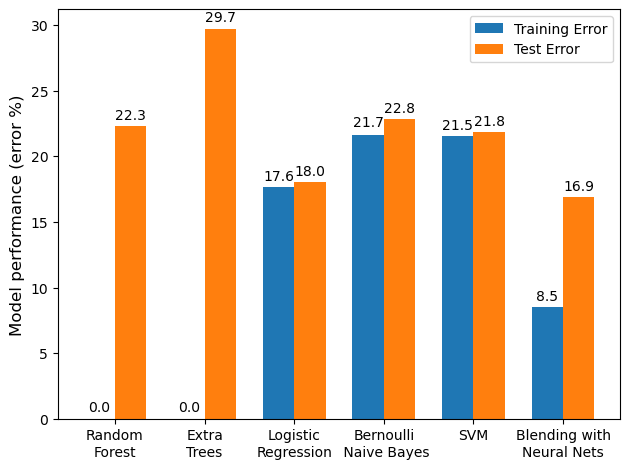

In [19]:
%matplotlib inline

labels = ['Random\nForest', 'Extra\nTrees', 'Logistic\nRegression', 
      'Bernoulli\n Naive Bayes', 'SVM', 'Blending with\nNeural Nets']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width / 2, trn_errors, width, label='Training Error')
rects2 = ax.bar(x + width / 2, tst_errors, width, label='Test Error')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model performance (error %)', fontsize=12)
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.legend()

ax.set_axisbelow(True)
# ax.grid(linestyle='-', linewidth='0.5', color='gray')

autolabel(ax, rects1)
autolabel(ax, rects2)

fig.tight_layout()
# plt.savefig('./figures/CH03_F19_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH03_F19_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)